In [1]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

## Creating target variable
Following the paper https://arxiv.org/pdf/1703.07771
--> They are not using HOSPITAL_EXPIRE_FLAG

In [29]:
# Path to your zip file
zip_path = r"C:\Users\maxim\Downloads\mimic-iii-clinical-database-1.4.zip"

# Load required tables
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Load ICUSTAYS
    with zip_ref.open('mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz') as gz_file:
        icustays = pd.read_csv(gz_file, compression='gzip')
    
    # Load PATIENTS (needed for age calculation)
    with zip_ref.open('mimic-iii-clinical-database-1.4/PATIENTS.csv.gz') as gz_file:
        patients = pd.read_csv(gz_file, compression='gzip')
    
    # Load ADMISSIONS (needed for in-hospital mortality)
    with zip_ref.open('mimic-iii-clinical-database-1.4/ADMISSIONS.csv.gz') as gz_file:
        admissions = pd.read_csv(gz_file, compression='gzip')

print(f"Starting with {len(icustays)} ICU stays")

# Convert date columns to datetime
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])
patients['DOB'] = pd.to_datetime(patients['DOB'])
patients['DOD'] = pd.to_datetime(patients['DOD'])
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
admissions['DEATHTIME'] = pd.to_datetime(admissions['DEATHTIME'])

# Merge to get patient DOB and DOD
df = icustays.merge(patients[['SUBJECT_ID', 'DOB', 'DOD']], on='SUBJECT_ID', how='left')

# Merge to get admission times and death time
df = df.merge(admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME']], 
              on=['SUBJECT_ID', 'HADM_ID'], how='left')

# Calculate age at ICU admission - handle overflow safely
df['age_years'] = df['INTIME'].dt.year - df['DOB'].dt.year

# Adjust for patients who haven't had their birthday yet this year
birthday_not_passed = (
    (df['INTIME'].dt.month < df['DOB'].dt.month) |
    ((df['INTIME'].dt.month == df['DOB'].dt.month) & (df['INTIME'].dt.day < df['DOB'].dt.day))
)
df.loc[birthday_not_passed, 'age_years'] -= 1

# MIMIC-III sets DOB to 300 years before admission for patients > 89
df.loc[df['age_years'] > 200, 'age_years'] = 90
df['AGE'] = df['age_years']

# EXCLUSION 1: Remove ICU stays with transfers
df = df[(df['FIRST_WARDID'] == df['LAST_WARDID']) & (df['FIRST_CAREUNIT'] == df['LAST_CAREUNIT'])]
print(f"After excluding ICU transfers: {len(df)}")

# EXCLUSION 2: Remove hospital admissions with multiple ICU stays
icu_stays_per_admission = df.groupby('HADM_ID').size()
single_icu_admissions = icu_stays_per_admission[icu_stays_per_admission == 1].index
df = df[df['HADM_ID'].isin(single_icu_admissions)]
print(f"After excluding multiple ICU stays per admission: {len(df)}")

# EXCLUSION 3: Remove patients younger than 18
df = df[df['AGE'] >= 18]
print(f"After excluding pediatric patients: {len(df)}")

# EXCLUSION 4: Remove ICU stays with LOS < 48 hours or unknown
# LOS is in days in MIMIC-III
df = df[df['LOS'].notna() & (df['LOS'] >= 2.0)]
print(f"After excluding LOS < 48 hours or unknown: {len(df)}")

# Calculate in-hospital mortality
# Patient died in hospital if:
# 1. DOD is not null AND death occurred between admission and discharge
# 2. OR DEATHTIME is not null AND death occurred between admission and discharge
mortality_dod = df['DOD'].notna() & (df['ADMITTIME'] <= df['DOD']) & (df['DOD'] <= df['DISCHTIME'])
mortality_deathtime = df['DEATHTIME'].notna() & (df['ADMITTIME'] <= df['DEATHTIME']) & (df['DEATHTIME'] <= df['DISCHTIME'])
df['MORTALITY_INHOSPITAL'] = (mortality_dod | mortality_deathtime).astype(int)

# Select final columns
final_df = df[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'MORTALITY_INHOSPITAL']].copy()

print(f"\n=== FINAL RESULT ===")
print(f"Total ICU stays: {len(final_df)}")
print(f"Unique patients: {final_df['SUBJECT_ID'].nunique()}")
print(f"Deaths (in-hospital mortality): {final_df['MORTALITY_INHOSPITAL'].sum()}")
print(f"Mortality rate: {final_df['MORTALITY_INHOSPITAL'].mean()*100:.2f}%")
print(f"\nFirst few rows:")
print(final_df.head(10))

Starting with 61532 ICU stays
After excluding ICU transfers: 55830
After excluding multiple ICU stays per admission: 50186
After excluding pediatric patients: 42276
After excluding LOS < 48 hours or unknown: 21247

=== FINAL RESULT ===
Total ICU stays: 21247
Unique patients: 18134
Deaths (in-hospital mortality): 2798
Mortality rate: 13.17%

First few rows:
    SUBJECT_ID  HADM_ID  ICUSTAY_ID  MORTALITY_INHOSPITAL
0          268   110404      280836                     1
1          269   106296      206613                     0
2          270   188028      220345                     0
6          274   130546      254851                     0
7          275   129886      219649                     1
10         279   192224      204407                     0
12         281   111199      257572                     1
14         283   109185      231490                     0
15         283   144156      280531                     0
17         285   165312      238023                     0


In [30]:
# Export target variabe
final_df.to_csv('inhospital_mortality.csv', index=False)

### Compare created target variable with HOSPITAL_EXPIRE_FLAG 
Do they differ?

In [7]:
# Path to your zip file
zip_path = r"C:\Users\maxim\Downloads\mimic-iii-clinical-database-1.4.zip"

# Load required tables
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz') as gz_file:
        icustays = pd.read_csv(gz_file, compression='gzip')
    
    with zip_ref.open('mimic-iii-clinical-database-1.4/PATIENTS.csv.gz') as gz_file:
        patients = pd.read_csv(gz_file, compression='gzip')
    
    with zip_ref.open('mimic-iii-clinical-database-1.4/ADMISSIONS.csv.gz') as gz_file:
        admissions = pd.read_csv(gz_file, compression='gzip')

print(f"Starting with {len(icustays)} ICU stays")

# Convert date columns to datetime
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])
patients['DOB'] = pd.to_datetime(patients['DOB'])
patients['DOD'] = pd.to_datetime(patients['DOD'])
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
admissions['DEATHTIME'] = pd.to_datetime(admissions['DEATHTIME'])

# Merge to get patient DOB and DOD
df = icustays.merge(patients[['SUBJECT_ID', 'DOB', 'DOD']], on='SUBJECT_ID', how='left')

# Merge to get admission times, death time, AND HOSPITAL_EXPIRE_FLAG
df = df.merge(admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG']], 
              on=['SUBJECT_ID', 'HADM_ID'], how='left')

# Calculate age at ICU admission
df['age_years'] = df['INTIME'].dt.year - df['DOB'].dt.year
birthday_not_passed = (
    (df['INTIME'].dt.month < df['DOB'].dt.month) |
    ((df['INTIME'].dt.month == df['DOB'].dt.month) & (df['INTIME'].dt.day < df['DOB'].dt.day))
)
df.loc[birthday_not_passed, 'age_years'] -= 1
df.loc[df['age_years'] > 200, 'age_years'] = 90
df['AGE'] = df['age_years']

# Apply all exclusions
df = df[(df['FIRST_WARDID'] == df['LAST_WARDID']) & (df['FIRST_CAREUNIT'] == df['LAST_CAREUNIT'])]
print(f"After excluding ICU transfers: {len(df)}")

icu_stays_per_admission = df.groupby('HADM_ID').size()
single_icu_admissions = icu_stays_per_admission[icu_stays_per_admission == 1].index
df = df[df['HADM_ID'].isin(single_icu_admissions)]
print(f"After excluding multiple ICU stays per admission: {len(df)}")

df = df[df['AGE'] >= 18]
print(f"After excluding pediatric patients: {len(df)}")

df = df[df['LOS'].notna() & (df['LOS'] >= 2.0)]
print(f"After excluding LOS < 48 hours or unknown: {len(df)}")

# Calculate custom in-hospital mortality
mortality_dod = df['DOD'].notna() & (df['ADMITTIME'] <= df['DOD']) & (df['DOD'] <= df['DISCHTIME'])
mortality_deathtime = df['DEATHTIME'].notna() & (df['ADMITTIME'] <= df['DEATHTIME']) & (df['DEATHTIME'] <= df['DISCHTIME'])
df['MORTALITY_INHOSPITAL'] = (mortality_dod | mortality_deathtime).astype(int)

# ===== COMPARISON ANALYSIS =====
print("\n" + "="*70)
print("COMPARISON: MORTALITY_INHOSPITAL vs HOSPITAL_EXPIRE_FLAG")
print("="*70)

# Basic statistics
print(f"\nCustom MORTALITY_INHOSPITAL:")
print(f"  Deaths: {df['MORTALITY_INHOSPITAL'].sum()}")
print(f"  Rate: {df['MORTALITY_INHOSPITAL'].mean()*100:.2f}%")

print(f"\nMIMIC-III HOSPITAL_EXPIRE_FLAG:")
print(f"  Deaths: {df['HOSPITAL_EXPIRE_FLAG'].sum()}")
print(f"  Rate: {df['HOSPITAL_EXPIRE_FLAG'].mean()*100:.2f}%")

# Agreement analysis
agreement = (df['MORTALITY_INHOSPITAL'] == df['HOSPITAL_EXPIRE_FLAG']).sum()
disagreement = (df['MORTALITY_INHOSPITAL'] != df['HOSPITAL_EXPIRE_FLAG']).sum()

print(f"\n--- Agreement Analysis ---")
print(f"Cases where both agree: {agreement} ({agreement/len(df)*100:.2f}%)")
print(f"Cases where they differ: {disagreement} ({disagreement/len(df)*100:.2f}%)")

# Detailed breakdown of differences
if disagreement > 0:
    print(f"\n--- Breakdown of Differences ---")
    
    # Custom says dead, MIMIC says alive
    custom_dead_mimic_alive = (df['MORTALITY_INHOSPITAL'] == 1) & (df['HOSPITAL_EXPIRE_FLAG'] == 0)
    print(f"Custom=DEAD, MIMIC=ALIVE: {custom_dead_mimic_alive.sum()} cases")
    
    # Custom says alive, MIMIC says dead
    custom_alive_mimic_dead = (df['MORTALITY_INHOSPITAL'] == 0) & (df['HOSPITAL_EXPIRE_FLAG'] == 1)
    print(f"Custom=ALIVE, MIMIC=DEAD: {custom_alive_mimic_dead.sum()} cases")
    
    # Show examples of discrepancies
    print(f"\n--- Examples of Discrepancies ---")
    discrepancies = df[df['MORTALITY_INHOSPITAL'] != df['HOSPITAL_EXPIRE_FLAG']].copy()
    
    if len(discrepancies) > 0:
        
        # Cases where custom=1, MIMIC=0
        if custom_dead_mimic_alive.sum() > 0:
            subset = discrepancies[discrepancies['MORTALITY_INHOSPITAL'] == 1]
            print(f"\nCases marked as DEAD by custom but ALIVE by MIMIC ({len(subset)} cases):")
            print(f"  - Has DEATHTIME: {subset['DEATHTIME'].notna().sum()}")
            print(f"  - Has DOD: {subset['DOD'].notna().sum()}")
            print(f"  - Death within admission window: {((subset['ADMITTIME'] <= subset['DEATHTIME']) & (subset['DEATHTIME'] <= subset['DISCHTIME'])).sum()}")
        
        # Cases where custom=0, MIMIC=1
        if custom_alive_mimic_dead.sum() > 0:
            subset = discrepancies[discrepancies['HOSPITAL_EXPIRE_FLAG'] == 1]
            print(f"\nCases marked as ALIVE by custom but DEAD by MIMIC ({len(subset)} cases):")
            print(f"  - Has DEATHTIME: {subset['DEATHTIME'].notna().sum()}")
            print(f"  - Has DOD: {subset['DOD'].notna().sum()}")
            print(f"  - DEATHTIME is null: {subset['DEATHTIME'].isna().sum()}")
            print(f"  - DOD is null: {subset['DOD'].isna().sum()}")

# Confusion matrix
print(f"\n--- Confusion Matrix ---")
print(f"                          HOSPITAL_EXPIRE_FLAG")
print(f"                          Alive(0)  Dead(1)")
print(f"MORTALITY_     Alive(0)  {((df['MORTALITY_INHOSPITAL']==0) & (df['HOSPITAL_EXPIRE_FLAG']==0)).sum():7d}  {((df['MORTALITY_INHOSPITAL']==0) & (df['HOSPITAL_EXPIRE_FLAG']==1)).sum():7d}")
print(f"INHOSPITAL     Dead(1)   {((df['MORTALITY_INHOSPITAL']==1) & (df['HOSPITAL_EXPIRE_FLAG']==0)).sum():7d}  {((df['MORTALITY_INHOSPITAL']==1) & (df['HOSPITAL_EXPIRE_FLAG']==1)).sum():7d}")

print("\n" + "="*70)
print("CONCLUSION:")
if disagreement == 0:
    print("✓ The variables are IDENTICAL - no differences found!")
else:
    print(f"✗ The variables DIFFER in {disagreement} cases ({disagreement/len(df)*100:.2f}%)")
    print("  Review the discrepancies above to understand the differences.")
print("="*70)

Starting with 61532 ICU stays
After excluding ICU transfers: 55830
After excluding multiple ICU stays per admission: 50186
After excluding pediatric patients: 42276
After excluding LOS < 48 hours or unknown: 21247

COMPARISON: MORTALITY_INHOSPITAL vs HOSPITAL_EXPIRE_FLAG

Custom MORTALITY_INHOSPITAL:
  Deaths: 2798
  Rate: 13.17%

MIMIC-III HOSPITAL_EXPIRE_FLAG:
  Deaths: 2775
  Rate: 13.06%

--- Agreement Analysis ---
Cases where both agree: 21178 (99.68%)
Cases where they differ: 69 (0.32%)

--- Breakdown of Differences ---
Custom=DEAD, MIMIC=ALIVE: 46 cases
Custom=ALIVE, MIMIC=DEAD: 23 cases

--- Examples of Discrepancies ---

Cases marked as DEAD by custom but ALIVE by MIMIC (46 cases):
  - Has DEATHTIME: 0
  - Has DOD: 46
  - Death within admission window: 0

Cases marked as ALIVE by custom but DEAD by MIMIC (23 cases):
  - Has DEATHTIME: 23
  - Has DOD: 23
  - DEATHTIME is null: 0
  - DOD is null: 0

--- Confusion Matrix ---
                          HOSPITAL_EXPIRE_FLAG
        

In [4]:
discrepancies[cols_to_show].head(10)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HOSPITAL_EXPIRE_FLAG,ADMITTIME,DISCHTIME,DEATHTIME,DOD
674,937,148592,228181,0,1,2163-01-20 18:39:00,2163-01-24 08:00:00,2163-01-26 08:00:00,2163-01-26
2119,1501,194689,252718,1,0,2146-12-11 14:05:00,2146-12-26 14:39:00,NaT,2146-12-26
2353,2098,109937,242674,1,0,2157-12-22 14:57:00,2158-01-01 14:10:00,NaT,2158-01-01
2384,2224,199295,291115,1,0,2201-09-02 17:05:00,2201-09-23 14:15:00,NaT,2201-09-23
10012,8559,105407,277631,1,0,2153-08-15 14:13:00,2153-08-26 11:50:00,NaT,2153-08-26
10128,7928,124720,265607,1,0,2100-10-18 03:04:00,2100-10-21 14:30:00,NaT,2100-10-21
11219,7235,112214,240364,1,0,2150-03-04 04:18:00,2150-03-09 16:30:00,NaT,2150-03-09
12105,9896,165450,206333,0,1,2131-02-10 00:09:00,2131-02-11 14:45:00,2131-02-12 14:45:00,2131-02-12
12457,9827,106728,288790,1,0,2195-05-29 13:04:00,2195-06-18 15:05:00,NaT,2195-06-18
12624,13470,106132,247758,0,1,2156-12-21 01:58:00,2156-12-30 12:00:00,2156-12-31 12:00:00,2156-12-31


### Do these variables differ?
Yes, but only in 0.32% of all cases. This is either because the deathtime is after dischargetime (which indicates that a patient died not in hospital) or because no deathtime and only date of death is present. As we can see in the example above, a patient who died on day x and is "discharged" on the same day, but the deathtime is not present, HOSPITAL_EXPIRE_FLAG is 0. Does this make sense? 

Final conclusion: Both variables differ only in 0.32% of all cases. From looking at the discrepancies, the proposed calculation of MORTALITY_INHOSPITAL is plausible.

## Feature Extraction

### Hear Rate, Temperature, Respitory Rate (all from Chartevents)

In [2]:
zip_path = r"C:\Users\maxim\Downloads\mimic-iii-clinical-database-1.4.zip"

# Method 1: Load D_ITEMS table (the data dictionary)
# This is small and contains all item definitions
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/D_ITEMS.csv.gz') as gz_file:
        d_items = pd.read_csv(gz_file, compression='gzip')

# View all available information about items
print(d_items.columns)

Index(['ROW_ID', 'ITEMID', 'LABEL', 'ABBREVIATION', 'DBSOURCE', 'LINKSTO',
       'CATEGORY', 'UNITNAME', 'PARAM_TYPE', 'CONCEPTID'],
      dtype='object')


In [3]:
# Method 2: Search for specific items by keyword
def search_items(keyword, d_items):
    """Search for items containing a keyword"""
    mask = (d_items['LABEL'].str.contains(keyword, case=False, na=False) | 
            d_items['ABBREVIATION'].str.contains(keyword, case=False, na=False))
    return d_items[mask][['ITEMID', 'LABEL', 'ABBREVIATION', 'CATEGORY', 'UNITNAME', 'DBSOURCE']]

In [5]:
search_items('diastolic', d_items)

,ITEMID,LABEL,ABBREVIATION,CATEGORY,UNITNAME,DBSOURCE
417,153,Diastolic Unloading,NaN,NaN,NaN,carevue
4633,8364,ABP [Diastolic],NaN,NaN,NaN,carevue
4637,8368,Arterial BP [Diastolic],NaN,NaN,NaN,carevue
4709,8440,Manual BP [Diastolic],NaN,NaN,NaN,carevue
4710,8441,NBP [Diastolic],NaN,NaN,NaN,carevue
4713,8444,Orthostat BP sitting [Diastolic],NaN,NaN,NaN,carevue
4714,8445,OrthostatBP standing [Diastolic],NaN,NaN,NaN,carevue
4715,8446,Orthostatic BP lying [Diastolic],NaN,NaN,NaN,carevue
4717,8448,PAP [Diastolic],NaN,NaN,NaN,carevue
4759,8502,BP Cuff [Diastolic],NaN,NaN,NaN,carevue


In [13]:
del(chartevents)

NameError: name 'chartevents' is not defined

In [14]:
items = [211, 220045, 618, 220210, 676, 678, 223761, 223762]

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/CHARTEVENTS.csv.gz') as gz_file:
        chunk_iterator = pd.read_csv(gz_file, compression='gzip', chunksize=1_000_000)
        
        filtered_chunks = []
        for chunk in chunk_iterator:
            # Filter for specific items
            filtered = chunk[chunk['ITEMID'].isin(items)]
            if not filtered.empty:
                filtered_chunks.append(filtered)
        
        # Combine filtered chunks
        chartevents = pd.concat(filtered_chunks, ignore_index=True)

In [15]:
chartevents.head(4)

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,803,36,165660,241249.0,220045,2134-05-12 13:00:00,2134-05-12 13:55:00,17525.0,86.0,86.0,bpm,0.0,0.0,NaN,NaN
1,807,36,165660,241249.0,220210,2134-05-12 13:00:00,2134-05-12 13:55:00,17525.0,21.0,21.0,insp/min,0.0,0.0,NaN,NaN
2,816,36,165660,241249.0,220045,2134-05-12 14:00:00,2134-05-12 14:39:00,17525.0,85.0,85.0,bpm,0.0,0.0,NaN,NaN
3,820,36,165660,241249.0,220210,2134-05-12 14:00:00,2134-05-12 14:39:00,17525.0,19.0,19.0,insp/min,0.0,0.0,NaN,NaN


In [16]:
chartevents['VALUEUOM'].unique()

array(['bpm', 'insp/min', '?F', '?C', 'BPM', 'Deg. F', 'Deg. C', nan],
      dtype=object)

In [17]:
# Load ICUSTAYS table
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz') as gz_file:
        icustays = pd.read_csv(gz_file, compression='gzip')

# Convert datetime columns
chartevents['CHARTTIME'] = pd.to_datetime(chartevents['CHARTTIME'])
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])

### Creating a new dataframe, which contains Hear Rate, Temperature and Respitory Rate and the target variable

In [21]:
final_df = pd.read_csv('inhospital_mortality.csv')
final_df.head(3)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL
0,268,110404,280836,1
1,269,106296,206613,0
2,270,188028,220345,0


In [22]:
# Convert datetime columns if not already done
chartevents['CHARTTIME'] = pd.to_datetime(chartevents['CHARTTIME'])
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])

# Merge chartevents with ICUSTAYS to get admission times
chartevents_with_time = chartevents.merge(
    icustays[['ICUSTAY_ID', 'INTIME']], 
    on='ICUSTAY_ID', 
    how='inner'
)

# Calculate hours from admission
chartevents_with_time['HOURS_FROM_ADMISSION'] = (
    chartevents_with_time['CHARTTIME'] - chartevents_with_time['INTIME']
).dt.total_seconds() / 3600

# Filter for first 48 hours
chartevents_48h = chartevents_with_time[
    (chartevents_with_time['HOURS_FROM_ADMISSION'] >= 0) & 
    (chartevents_with_time['HOURS_FROM_ADMISSION'] <= 48)
].copy()

# ============================================================================
# 1. HEART RATE
# ============================================================================
hr_itemids = [211, 220045]
hr_data = chartevents_48h[chartevents_48h['ITEMID'].isin(hr_itemids)].copy()

# Clean heart rate data (valid range: 20-250 bpm)
hr_data = hr_data[
    (hr_data['VALUENUM'].notna()) & 
    (hr_data['VALUENUM'] > 0) & 
    (hr_data['VALUENUM'] < 350)
]

# Calculate average HR per ICU stay
hr_features = hr_data.groupby('ICUSTAY_ID').agg({
    'VALUENUM': ['mean', 'median', 'std', 'min', 'max', 'count']
}).reset_index()

hr_features.columns = [
    'ICUSTAY_ID', 'HR_MEAN', 'HR_MEDIAN', 'HR_STD',
    'HR_MIN', 'HR_MAX', 'HR_COUNT'
]

# ============================================================================
# 2. RESPIRATORY RATE
# ============================================================================
rr_itemids = [618, 220210]
rr_data = chartevents_48h[chartevents_48h['ITEMID'].isin(rr_itemids)].copy()

# Clean respiratory rate data (valid range: 5-60 breaths/min)
rr_data = rr_data[
    (rr_data['VALUENUM'].notna()) & 
    (rr_data['VALUENUM'] > 0) & 
    (rr_data['VALUENUM'] < 300)
]

# Calculate average RR per ICU stay
rr_features = rr_data.groupby('ICUSTAY_ID').agg({
    'VALUENUM': ['mean', 'median', 'std', 'min', 'max', 'count']
}).reset_index()
rr_features.columns = ['ICUSTAY_ID', 'RR_MEAN', 'RR_MEDIAN', 'RR_STD', 'RR_MIN', 'RR_MAX', 'RR_COUNT']

# ============================================================================
# 3. TEMPERATURE (Convert all to Celsius)
# ============================================================================
temp_itemids = [676, 678, 223761, 223762]
temp_data = chartevents_48h[chartevents_48h['ITEMID'].isin(temp_itemids)].copy()

# Convert Fahrenheit to Celsius
# ITEMIDs 678 and 223761 are in Fahrenheit
fahrenheit_itemids = [678, 223761]
temp_data['TEMP_CELSIUS'] = temp_data['VALUENUM']

# Convert F to C: (F - 32) * 5/9
temp_data.loc[temp_data['ITEMID'].isin(fahrenheit_itemids), 'TEMP_CELSIUS'] = (
    (temp_data.loc[temp_data['ITEMID'].isin(fahrenheit_itemids), 'VALUENUM'] - 32) * 5 / 9
)

# Clean temperature data (valid range: 25-45°C, which is ~77-113°F)
temp_data = temp_data[
    (temp_data['TEMP_CELSIUS'].notna()) & 
    (temp_data['TEMP_CELSIUS'] > 26) & 
    (temp_data['TEMP_CELSIUS'] < 45)
]

# Calculate average temperature per ICU stay
temp_features = temp_data.groupby('ICUSTAY_ID').agg({
    'TEMP_CELSIUS': ['mean', 'median', 'std', 'min', 'max', 'count']
}).reset_index()
temp_features.columns = ['ICUSTAY_ID', 'TEMP_MEAN', 'TEMP_MEDIAN', 'TEMP_STD', 'TEMP_MIN', 'TEMP_MAX', 'TEMP_COUNT']

# ============================================================================
# 4. MERGE ALL FEATURES INTO FINAL DATAFRAME
# ============================================================================
# Start with your original final_df
final_df_complete = final_df.copy()

# Merge heart rate features
final_df_complete = final_df_complete.merge(hr_features, on='ICUSTAY_ID', how='left')

# Merge respiratory rate features
final_df_complete = final_df_complete.merge(rr_features, on='ICUSTAY_ID', how='left')

# Merge temperature features
final_df_complete = final_df_complete.merge(temp_features, on='ICUSTAY_ID', how='left')

# ============================================================================
# 5. SUMMARY STATISTICS
# ============================================================================
print("=" * 80)
print("DATA COMPLETENESS SUMMARY")
print("=" * 80)
print(f"\nTotal ICU stays: {len(final_df_complete)}")
print(f"\nICU stays with data:")
print(f"  Heart Rate:       {final_df_complete['HR_MEAN'].notna().sum()} ({final_df_complete['HR_MEAN'].notna().sum()/len(final_df_complete)*100:.1f}%)")
print(f"  Respiratory Rate: {final_df_complete['RR_MEAN'].notna().sum()} ({final_df_complete['RR_MEAN'].notna().sum()/len(final_df_complete)*100:.1f}%)")
print(f"  Temperature:      {final_df_complete['TEMP_MEAN'].notna().sum()} ({final_df_complete['TEMP_MEAN'].notna().sum()/len(final_df_complete)*100:.1f}%)")

print("\n" + "=" * 80)
print("VITAL SIGNS STATISTICS (First 48 hours)")
print("=" * 80)

print("\nHeart Rate (bpm):")
print(final_df_complete['HR_MEAN'].describe())

print("\nRespiratory Rate (breaths/min):")
print(final_df_complete['RR_MEAN'].describe())

print("\nTemperature (°C):")
print(final_df_complete['TEMP_MEAN'].describe())

# Show sample of the complete dataframe
print("\n" + "=" * 80)
print("SAMPLE OF FINAL DATAFRAME")
print("=" * 80)
cols_to_show = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'MORTALITY_INHOSPITAL',
                'HR_MEAN', 'RR_MEAN', 'TEMP_MEAN', 'HR_COUNT', 'RR_COUNT', 'TEMP_COUNT']
print(final_df_complete[cols_to_show].head(10))

# Check for complete cases (all three vitals available)
complete_cases = (
    final_df_complete['HR_MEAN'].notna() & 
    final_df_complete['RR_MEAN'].notna() & 
    final_df_complete['TEMP_MEAN'].notna()
)
print(f"\nICU stays with all three vitals: {complete_cases.sum()} ({complete_cases.sum()/len(final_df_complete)*100:.1f}%)")

DATA COMPLETENESS SUMMARY

Total ICU stays: 21247

ICU stays with data:
  Heart Rate:       20943 (98.6%)
  Respiratory Rate: 20930 (98.5%)
  Temperature:      20778 (97.8%)

VITAL SIGNS STATISTICS (First 48 hours)

Heart Rate (bpm):
count    20943.000000
mean        86.688100
std         14.808385
min         35.936170
25%         76.258940
50%         85.854167
75%         96.685876
max        154.448980
Name: HR_MEAN, dtype: float64

Respiratory Rate (breaths/min):
count    20930.000000
mean        19.341067
std          3.881178
min          8.325581
25%         16.609064
50%         18.816327
75%         21.530612
max         42.809524
Name: RR_MEAN, dtype: float64

Temperature (°C):
count    20778.000000
mean        36.916801
std          0.578768
min         31.600000
25%         36.538462
50%         36.888889
75%         37.282408
max         40.100000
Name: TEMP_MEAN, dtype: float64

SAMPLE OF FINAL DATAFRAME
   SUBJECT_ID  HADM_ID  ICUSTAY_ID  MORTALITY_INHOSPITAL     HR_MEA

In [23]:
# df was exported
final_df_complete = pd.read_csv('hr_rr_t_mortality.csv')

In [24]:
final_df_complete.head(3)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,RR_STD,RR_MIN,RR_MAX,RR_COUNT,TEMP_MEAN,TEMP_MEDIAN,TEMP_STD,TEMP_MIN,TEMP_MAX,TEMP_COUNT
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,6.555936,9.0,38.0,29.0,38.085860,38.111110,0.789344,37.111113,39.333335,11.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,5.623460,12.0,38.0,49.0,38.252136,37.888887,0.790769,37.277777,39.777777,13.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,2.579112,9.0,23.0,63.0,36.555555,36.583335,0.192450,36.222221,36.777776,8.0


### Add new features: Age, Gender

In [25]:
zip_path = r"C:\Users\maxim\Downloads\mimic-iii-clinical-database-1.4.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Load PATIENTS table
    with zip_ref.open('mimic-iii-clinical-database-1.4/PATIENTS.csv.gz') as gz_file:
        patients = pd.read_csv(gz_file, compression='gzip')
    
    # Load ICUSTAYS table (to get INTIME for age calculation)
    with zip_ref.open('mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz') as gz_file:
        icustays = pd.read_csv(gz_file, compression='gzip')

# Convert date columns to datetime
patients['DOB'] = pd.to_datetime(patients['DOB'])
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])

In [26]:
# ============================================================================
# CALCULATE AGE
# ============================================================================

# Merge to get DOB for each ICU stay
age_gender_df = final_df_complete[['SUBJECT_ID', 'ICUSTAY_ID']].merge(
    icustays[['SUBJECT_ID', 'ICUSTAY_ID', 'INTIME']], 
    on=['SUBJECT_ID', 'ICUSTAY_ID'], 
    how='left'
)

age_gender_df = age_gender_df.merge(
    patients[['SUBJECT_ID', 'DOB', 'GENDER']], 
    on='SUBJECT_ID', 
    how='left'
)

# Calculate age at ICU admission - handle overflow safely
age_gender_df['age_years'] = age_gender_df['INTIME'].dt.year - age_gender_df['DOB'].dt.year

# Adjust for patients who haven't had their birthday yet this year
birthday_not_passed = (
    (age_gender_df['INTIME'].dt.month < age_gender_df['DOB'].dt.month) |
    ((age_gender_df['INTIME'].dt.month == age_gender_df['DOB'].dt.month) & 
     (age_gender_df['INTIME'].dt.day < age_gender_df['DOB'].dt.day))
)
age_gender_df.loc[birthday_not_passed, 'age_years'] -= 1

# MIMIC-III sets DOB to 300 years before admission for patients > 89
age_gender_df.loc[age_gender_df['age_years'] > 200, 'age_years'] = 90

# Rename columns
age_gender_df['AGE'] = age_gender_df['age_years']

# Select only the columns we need
age_gender_features = age_gender_df[['ICUSTAY_ID', 'AGE', 'GENDER']].copy()

In [27]:
# Create a NEW dataframe
final_df_with_demographics = final_df_complete.merge(
    age_gender_features, 
    on='ICUSTAY_ID', 
    how='left'
)

In [28]:
# Convert gender to binary (0 = Female, 1 = Male) for modeling
final_df_with_demographics['GENDER_BINARY'] = (final_df_with_demographics['GENDER'] == 'M').astype(int)

In [29]:
final_df_with_demographics.head(3)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,RR_COUNT,TEMP_MEAN,TEMP_MEDIAN,TEMP_STD,TEMP_MIN,TEMP_MAX,TEMP_COUNT,AGE,GENDER,GENDER_BINARY
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,29.0,38.085860,38.111110,0.789344,37.111113,39.333335,11.0,65,F,0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,49.0,38.252136,37.888887,0.790769,37.277777,39.777777,13.0,40,M,1
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,63.0,36.555555,36.583335,0.192450,36.222221,36.777776,8.0,80,M,1


In [30]:
print('Age charcteristics by Mortality')
final_df_with_demographics.groupby('MORTALITY_INHOSPITAL')['AGE'].describe()

Age charcteristics by Mortality


,count,mean,std,min,25%,50%,75%,max
MORTALITY_INHOSPITAL,,,,,,,,
0,18449.0,63.655862,16.997867,18.0,53.0,65.0,77.0,90.0
1,2798.0,69.485347,15.662818,18.0,60.0,73.0,82.0,90.0


In [31]:
mortality_gender = pd.crosstab(
    final_df_with_demographics['GENDER'], 
    final_df_with_demographics['MORTALITY_INHOSPITAL'],
    normalize='index'
) * 100
print('Gender Distribution by Mortality:')
print(' ')
print(mortality_gender)

Gender Distribution by Mortality:
 
MORTALITY_INHOSPITAL          0          1
GENDER                                    
F                     86.583708  13.416292
M                     87.033550  12.966450


In [32]:
final_df_with_demographics.to_csv('hr_rr_t_age_gender_mortality.csv', index = False)

### Expanded Dataframe: Anion Gap from Labevents

In [33]:
zip_path = r"C:\Users\maxim\Downloads\mimic-iii-clinical-database-1.4.zip"

# ============================================================================
# LOAD LABEVENTS DATA
# ============================================================================

# LABEVENTS is also very large, so we'll load in chunks and filter
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/LABEVENTS.csv.gz') as gz_file:
        chunk_iterator = pd.read_csv(gz_file, compression='gzip', chunksize=1_000_000)
        
        # Filter for Anion Gap ITEMIDs only
        ag_itemids = [50868, 52456] 
        
        ag_chunks = []
        for i, chunk in enumerate(chunk_iterator):
            print(f"Processing LABEVENTS chunk {i+1}...")
            filtered = chunk[chunk['ITEMID'].isin(ag_itemids)]
            if not filtered.empty:
                ag_chunks.append(filtered)
        
        labevents_ag = pd.concat(ag_chunks, ignore_index=True)

print(f"Loaded {len(labevents_ag)} Anion Gap measurements")

Processing LABEVENTS chunk 1...
Processing LABEVENTS chunk 2...
Processing LABEVENTS chunk 3...
Processing LABEVENTS chunk 4...
Processing LABEVENTS chunk 5...
Processing LABEVENTS chunk 6...
Processing LABEVENTS chunk 7...
Processing LABEVENTS chunk 8...
Processing LABEVENTS chunk 9...
Processing LABEVENTS chunk 10...
Processing LABEVENTS chunk 11...
Processing LABEVENTS chunk 12...
Processing LABEVENTS chunk 13...
Processing LABEVENTS chunk 14...
Processing LABEVENTS chunk 15...
Processing LABEVENTS chunk 16...
Processing LABEVENTS chunk 17...
Processing LABEVENTS chunk 18...
Processing LABEVENTS chunk 19...
Processing LABEVENTS chunk 20...
Processing LABEVENTS chunk 21...
Processing LABEVENTS chunk 22...
Processing LABEVENTS chunk 23...
Processing LABEVENTS chunk 24...
Processing LABEVENTS chunk 25...
Processing LABEVENTS chunk 26...
Processing LABEVENTS chunk 27...
Processing LABEVENTS chunk 28...
Loaded 769810 Anion Gap measurements


In [37]:
# Load D_LABITEMS to verify the correct ITEMIDs
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/D_LABITEMS.csv.gz') as gz_file:
        d_labitems = pd.read_csv(gz_file, compression='gzip')

# Search for Anion Gap
print("\n" + "=" * 80)
print("SEARCHING FOR ANION GAP IN D_LABITEMS")
print("=" * 80)
anion_gap_items = d_labitems[d_labitems['LABEL'].str.contains('anion', case=False, na=False)]
print(anion_gap_items[['ITEMID', 'LABEL', 'FLUID', 'CATEGORY']])


SEARCHING FOR ANION GAP IN D_LABITEMS
     ITEMID      LABEL  FLUID   CATEGORY
195   50868  Anion Gap  Blood  Chemistry


In [35]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Load PATIENTS table
    with zip_ref.open('mimic-iii-clinical-database-1.4/PATIENTS.csv.gz') as gz_file:
        patients = pd.read_csv(gz_file, compression='gzip')
    
    # Load ICUSTAYS table
    with zip_ref.open('mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz') as gz_file:
        icustays = pd.read_csv(gz_file, compression='gzip')

In [36]:
labevents_ag

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,292,3,NaN,50868,2101-10-13 03:00:00,13,13.0,mEq/L,NaN
1,305,3,NaN,50868,2101-10-13 15:47:00,14,14.0,mEq/L,NaN
2,317,3,NaN,50868,2101-10-14 03:00:00,12,12.0,mEq/L,NaN
3,363,3,NaN,50868,2101-10-15 03:30:00,15,15.0,mEq/L,NaN
4,383,3,NaN,50868,2101-10-15 12:15:00,14,14.0,mEq/L,NaN
...,...,...,...,...,...,...,...,...,...
769805,27761820,98994,178949.0,50868,2137-08-12 02:18:00,17,17.0,mEq/L,NaN
769806,27764176,98994,178949.0,50868,2137-09-25 04:29:00,17,17.0,mEq/L,NaN
769807,27427188,96442,107499.0,50868,2115-05-28 04:38:00,12,12.0,mEq/L,NaN
769808,27427216,96442,120151.0,50868,2115-06-29 04:45:00,17,17.0,mEq/L,NaN


In [38]:
# Convert datetime columns
labevents_ag['CHARTTIME'] = pd.to_datetime(labevents_ag['CHARTTIME'])
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])

# Merge with ICUSTAYS to get admission times
labevents_ag_with_time = labevents_ag.merge(
    icustays[['ICUSTAY_ID', 'HADM_ID', 'INTIME']], 
    on=['HADM_ID'], 
    how='inner'
)

# Calculate hours from ICU admission
labevents_ag_with_time['HOURS_FROM_ADMISSION'] = (
    labevents_ag_with_time['CHARTTIME'] - labevents_ag_with_time['INTIME']
).dt.total_seconds() / 3600

# Filter for first 48 hours
labevents_ag_48h = labevents_ag_with_time[
    #(labevents_ag_with_time['HOURS_FROM_ADMISSION'] >= 0) & 
    (labevents_ag_with_time['HOURS_FROM_ADMISSION'] <= 48)
].copy()

In [39]:
ag_itemids = [50868] 
ag_data = labevents_ag_48h[labevents_ag_48h['ITEMID'].isin(ag_itemids)].copy()

# Clean Anion Gap data
ag_data = ag_data[
    (ag_data['VALUENUM'].notna()) & 
    (ag_data['VALUENUM'] >= 5) & 
    (ag_data['VALUENUM'] <= 50)
]

# Calculate average Anion Gap per ICU stay
ag_features = ag_data.groupby('ICUSTAY_ID').agg({
    'VALUENUM': ['mean', 'median', 'std', 'min', 'max', 'count']
}).reset_index()
ag_features.columns = ['ICUSTAY_ID', 'AG_MEAN', 'AG_MEDIAN', 'AG_STD', 'AG_MIN', 'AG_MAX', 'AG_COUNT']

In [40]:
ag_features

,ICUSTAY_ID,AG_MEAN,AG_MEDIAN,AG_STD,AG_MIN,AG_MAX,AG_COUNT
0,200001,12.200000,11.5,2.250926,9.0,17.0,10
1,200003,15.600000,15.0,3.577709,12.0,21.0,5
2,200006,12.666667,12.0,2.081666,11.0,15.0,3
3,200007,16.333333,17.0,2.081666,14.0,18.0,3
4,200009,9.500000,9.5,2.121320,8.0,11.0,2
...,...,...,...,...,...,...,...
55392,299993,9.750000,10.0,1.258306,8.0,11.0,4
55393,299994,16.769231,17.0,2.586949,14.0,24.0,13
55394,299995,12.666667,13.0,2.516611,10.0,15.0,3
55395,299998,11.600000,11.0,1.516575,10.0,14.0,5


In [41]:
# Merge with final_df_with_demographics
final_df_with_ag = final_df_with_demographics.merge(
    ag_features, 
    on='ICUSTAY_ID', 
    how='left'
)

In [42]:
final_df_with_ag.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'MORTALITY_INHOSPITAL',
       'HR_MEAN', 'HR_MEDIAN', 'HR_STD', 'HR_MIN', 'HR_MAX', 'HR_COUNT',
       'RR_MEAN', 'RR_MEDIAN', 'RR_STD', 'RR_MIN', 'RR_MAX', 'RR_COUNT',
       'TEMP_MEAN', 'TEMP_MEDIAN', 'TEMP_STD', 'TEMP_MIN', 'TEMP_MAX',
       'TEMP_COUNT', 'AGE', 'GENDER', 'GENDER_BINARY', 'AG_MEAN', 'AG_MEDIAN',
       'AG_STD', 'AG_MIN', 'AG_MAX', 'AG_COUNT'],
      dtype='object')

In [10]:
final_df_with_ag = pd.read_csv('hr_rr_temp_age_gender_ag_48h_mortality.csv')

In [43]:
final_df_with_ag.to_csv('hr_rr_temp_age_gender_ag_48h_mortality.csv', index=False)

### Systolic and Diastolic Blood Pressure

In [45]:
# Loading systolic and diastolic blood pressure rows from Chartevents
# ITEMIDs: invasive (arterial line) and non-invasive (cuff)
diastolic_items = [8368,8440,8441,8555,220180,220051]

# ITEMIDs: invasive (arterial line) and non-invasive (cuff)
systolic_items = [51,442,455,6701,220179,220050]

# Combine all blood pressure ITEMIDs
items = systolic_items + diastolic_items

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/CHARTEVENTS.csv.gz') as gz_file:
        chunk_iterator = pd.read_csv(gz_file, compression='gzip', chunksize=1_000_000)
        
        filtered_chunks = []
        for chunk in chunk_iterator:
            # Filter for specific items
            filtered = chunk[chunk['ITEMID'].isin(items)]
            if not filtered.empty:
                filtered_chunks.append(filtered)
        
        # Combine filtered chunks
        chartevents = pd.concat(filtered_chunks, ignore_index=True)

In [46]:
chartevents.head(3)

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,804,36,165660,241249.0,220179,2134-05-12 13:00:00,2134-05-12 13:55:00,17525.0,137.0,137.0,mmHg,0.0,0.0,NaN,NaN
1,805,36,165660,241249.0,220180,2134-05-12 13:00:00,2134-05-12 13:55:00,17525.0,72.0,72.0,mmHg,0.0,0.0,NaN,NaN
2,817,36,165660,241249.0,220179,2134-05-12 14:00:00,2134-05-12 14:39:00,17525.0,118.0,118.0,mmHg,0.0,0.0,NaN,NaN


In [47]:
# Systolic Blood Pressure
sysbp_itemids = [51, 442, 455, 6701, 220179, 220050]
sysbp_data = chartevents[chartevents['ITEMID'].isin(sysbp_itemids)].copy()

# Clean systolic BP data
sysbp_data = sysbp_data[
    (sysbp_data['VALUENUM'].notna()) & 
    (sysbp_data['VALUENUM'] > 0) & 
    (sysbp_data['VALUENUM'] < 375)
]

# Calculate aggregated features per ICU stay
sysbp_features = sysbp_data.groupby('ICUSTAY_ID').agg({
    'VALUENUM': ['mean', 'median', 'std', 'min', 'max', 'count']
}).reset_index()
sysbp_features.columns = ['ICUSTAY_ID', 'SYSBP_MEAN', 'SYSBP_MEDIAN', 'SYSBP_STD', 'SYSBP_MIN', 'SYSBP_MAX', 'SYSBP_COUNT']


# Diastolic Blood Pressure
diasbp_itemids = [8368, 8440, 8441, 8555, 220180, 220051]
diasbp_data = chartevents[chartevents['ITEMID'].isin(diasbp_itemids)].copy()

# Clean diastolic BP data
diasbp_data = diasbp_data[
    (diasbp_data['VALUENUM'].notna()) & 
    (diasbp_data['VALUENUM'] > 0) & 
    (diasbp_data['VALUENUM'] < 375)
]

# Calculate aggregated features per ICU stay
diasbp_features = diasbp_data.groupby('ICUSTAY_ID').agg({
    'VALUENUM': ['mean', 'median', 'std', 'min', 'max', 'count']
}).reset_index()
diasbp_features.columns = ['ICUSTAY_ID', 'DIASBP_MEAN', 'DIASBP_MEDIAN', 'DIASBP_STD', 'DIASBP_MIN', 'DIASBP_MAX', 'DIASBP_COUNT']

In [24]:
final_df_with_ag = pd.read_csv('hr_rr_temp_age_gender_ag_48h_mortality.csv')

In [48]:
final_df_with_ag.head(3)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,TEMP_COUNT,AGE,GENDER,GENDER_BINARY,AG_MEAN,AG_MEDIAN,AG_STD,AG_MIN,AG_MAX,AG_COUNT
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,11.0,65,F,0,13.9,14.5,1.370320,12.0,15.0,10.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,13.0,40,M,1,11.0,10.5,2.280351,9.0,15.0,6.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,8.0,80,M,1,15.5,16.0,2.516611,12.0,18.0,4.0


In [49]:
final_df = final_df_with_ag.merge(sysbp_features, on='ICUSTAY_ID', how='left') \
                                   .merge(diasbp_features, on='ICUSTAY_ID', how='left')

In [50]:
final_df.head(4)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,SYSBP_STD,SYSBP_MIN,SYSBP_MAX,SYSBP_COUNT,DIASBP_MEAN,DIASBP_MEDIAN,DIASBP_STD,DIASBP_MIN,DIASBP_MAX,DIASBP_COUNT
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,27.048903,15.0,162.0,98.0,52.326531,52.0,10.997446,12.0,86.0,98.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,9.154864,83.0,126.0,65.0,51.538462,51.0,8.739417,32.0,78.0,65.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,17.451830,71.0,163.0,79.0,48.594937,49.0,7.365058,33.0,71.0,79.0
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,17.360515,88.0,197.0,241.0,69.780083,70.0,8.684599,44.0,109.0,241.0


In [60]:
final_df.to_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality', index = False)

In [61]:
df = pd.read_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality')
df.head(3)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,SYSBP_STD,SYSBP_MIN,SYSBP_MAX,SYSBP_COUNT,DIASBP_MEAN,DIASBP_MEDIAN,DIASBP_STD,DIASBP_MIN,DIASBP_MAX,DIASBP_COUNT
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,27.048903,15.0,162.0,98.0,52.326531,52.0,10.997446,12.0,86.0,98.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,9.154864,83.0,126.0,65.0,51.538462,51.0,8.739417,32.0,78.0,65.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,17.451830,71.0,163.0,79.0,48.594937,49.0,7.365058,33.0,71.0,79.0


Correlation with MORTALITY_INHOSPITAL:
 MORTALITY_INHOSPITAL    1.000000
AG_MEAN                 0.206087
AG_MEDIAN               0.205093
AG_MAX                  0.181507
SYSBP_STD               0.169003
AG_MIN                  0.158614
RR_MEAN                 0.143682
RR_MEDIAN               0.135938
TEMP_STD                0.125694
AGE                     0.116350
HR_MAX                  0.114610
RR_MAX                  0.097837
HR_STD                  0.092862
HR_MEAN                 0.090780
RR_MIN                  0.087305
HR_MEDIAN               0.083724
DIASBP_STD              0.066074
AG_STD                  0.053867
SYSBP_MAX               0.045097
RR_STD                  0.043887
HR_MIN                  0.042619
TEMP_MAX                0.032089
DIASBP_MAX              0.029221
GENDER_BINARY          -0.006618
TEMP_MEAN              -0.048331
TEMP_MEDIAN            -0.050810
TEMP_MIN               -0.106522
DIASBP_MEDIAN          -0.123660
SYSBP_MEDIAN           -0.126007
DIA

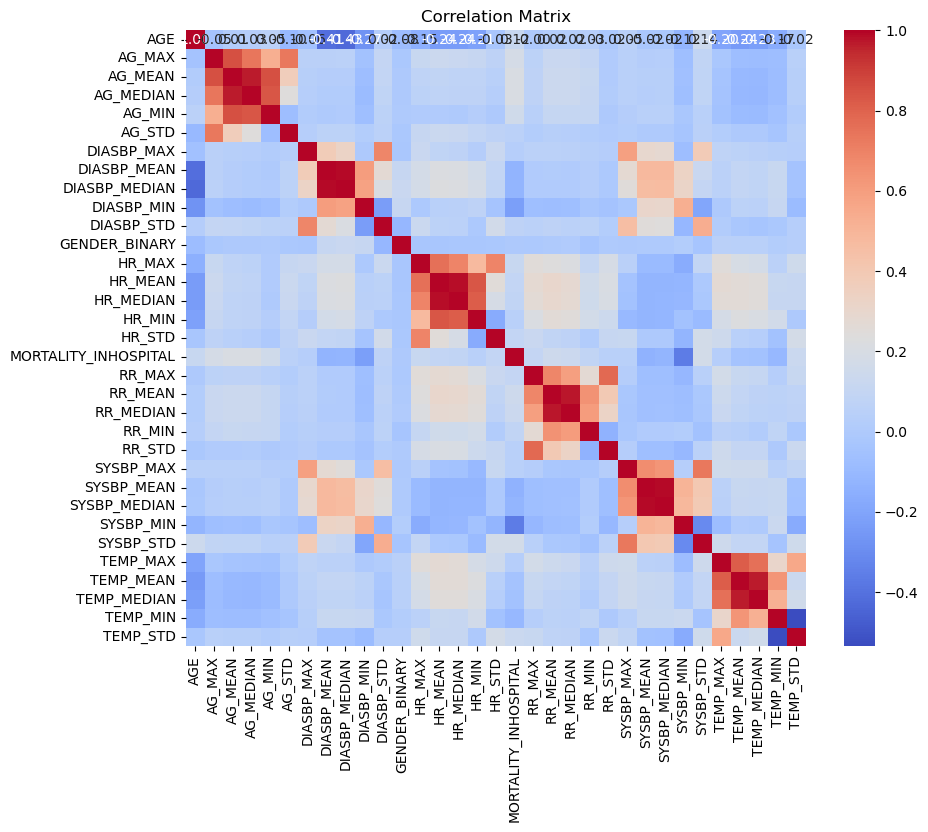

In [62]:
df_corr = df.copy()

numeric_cols = df_corr.select_dtypes(include=[np.number]).columns.tolist()

# Exclude columns
id_cols = ['SUBJECT_ID', 'ICUSTAY_ID', 'HADM_ID', 'HR_COUNT', 'SYSBP_COUNT', 'DIASBP_COUNT', 'TEMP_COUNT', 'AG_COUNT', 'RR_COUNT']
numeric_cols = [col for col in numeric_cols if col not in id_cols]

# Sort alphabetically
numeric_cols = sorted(numeric_cols)

df_numeric = df_corr[numeric_cols]
corr_matrix = df_numeric.corr()

# Show correlation of features with target
target_corr = corr_matrix['MORTALITY_INHOSPITAL'].sort_values(ascending=False)
print("Correlation with MORTALITY_INHOSPITAL:\n", target_corr)

# Optional: Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()